<h1>Generating Music using Deep Neural Networks:</h1>

I was very curious about how Recurrent Neural Networks are used to generate music which is what inspired me to go on to build this project. I will describe briefly about how I went about in building this system.

## Dataset:

-> The dataset used for training the model was encoded in a special way in which music is represented which is called "ABC notation".<br/>
-> The dataset had about 340 tunes which it was trained with and had  86 unique characters in the dataset.<br/>
-> Each of the characters are encoded as numbers. So we have a number between 0 and 85 representing each of the character in the dataset.

## Description of the Model and the input:

-> We are using a RNN based model here where we have an embedding layer in the beginnig which takes each input which is a number between 0 and 86 and converts them to a 512 dimension vector.<br/>
-> This input is then given to an RNN layer which is followed by 2 more RNN layers. We use a many to many network , hence an output is taken at each of the time steps. Hence we have a time distributed Dense layer after the RNN layers which is a dense layer giving 86 probabilities.<br/>
-> The 86 probabilities are then pased to a multiclass-log loss function.

## The model looks like the follows:

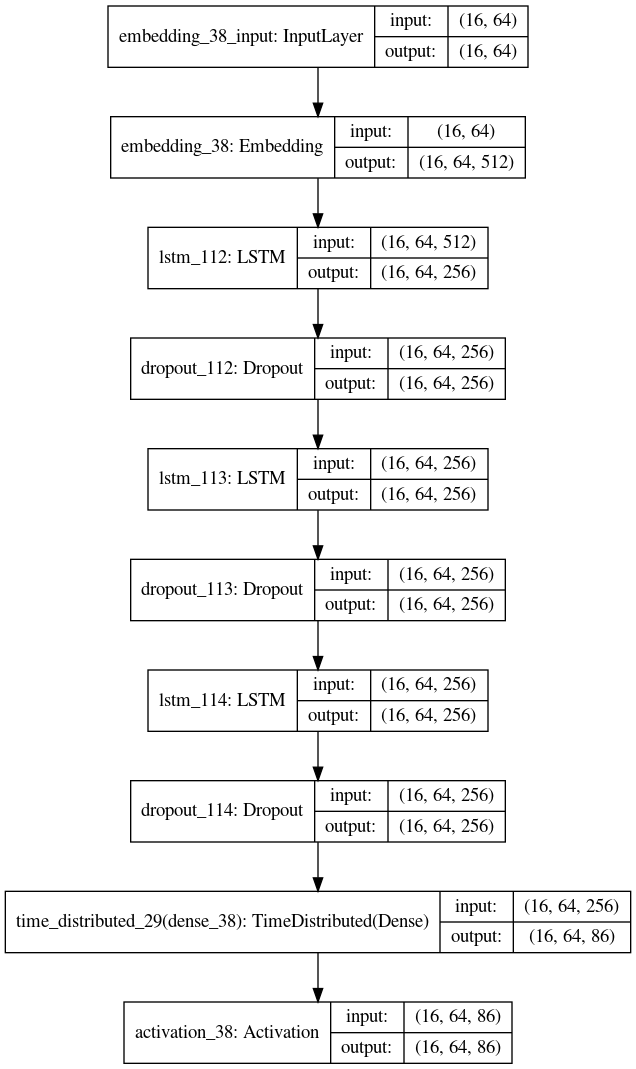

In [94]:
modelo=build_model(16,64,86)
plot_model(modelo,show_shapes=True)

## Preparation of the dataset for input:

-> The dataset is totally 129665 characters long. This is divided into batches of 16 in which each of the training sample has 64 characters each. Hence the batch shape is going to be a 16X64 matrix and the label will be a 16X64X86 matrix in which each 86 dimensionsal vector is a one-hot encoded version of the character which occurs exactly at one position after the corresponding cell in the input. For eaxmple, the cell 1X2 in the input batch will have a one-hot encoded vector version of the character which occurs at 1X3 in the input.

## An example output:

M9gj2n8A2 E2e|d2e e2d|G3 :|\ne2d c2B|ABc dBc|dBg dBG|\nccc d2e|B2B dBG|EEF G2D|G3 :|\n\n\nX: 136\nT:Gianson\'s Jig\n% Nottingham Music Database\nS:Trad, arr Phil Rowe\nM:6/8\nK:G\ndf|:"G""Bb"DFB "Am"ABc|"Bm"Bba "Em"gag|"Bm"fef "F#7"edc|"Bm"BcB B::\nf2e -def|"Em"g2b g2b|"F#7"f2f "Bm"f2d|"Em"e2d "A7"e2f|\n"D7"ded cB

<b> An example of the output generated can be seen above. To test it out, all you have to do is copy and paste the above in the link below</b>

## Importing the necessary libraries:

In [96]:
import numpy as np
import os
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, TimeDistributed, Dense, Activation, Embedding
import json
from tqdm.auto import tqdm
from keras.utils import plot_model
from IPython.display import Image
from IPython.core.display import HTML

## Defining the log files where data will be stored:

<b>Below we also define how large each of the batches should be and the length of each of the sequences</b>

In [15]:
DATA_DIR = './new'
LOG_DIR = './logs'
BATCH_SIZE = 16
SEQ_LENGTH = 64

## We define a logging function which help store the accuracy and other details at every 10 epochs:

In [16]:
class TrainLogger(object):
    def __init__(self, file):
        self.file = os.path.join(LOG_DIR, file)
        self.epochs = 0
        with open(self.file, 'w') as f:
            f.write('epoch,loss,acc\n')

    def add_entry(self, loss, acc):
        self.epochs += 1
        s = '{},{},{}\n'.format(self.epochs, loss, acc)
        with open(self.file, 'a') as f:
            f.write(s)

## A function to read the data from the files batch by batch. Basically we are creating a generator here

In [28]:
def read_batches(T, vocab_size):
    length = T.shape[0]; #129,665
    batch_chars = int(length / BATCH_SIZE); # 8,104

    for start in range(0, batch_chars - SEQ_LENGTH, SEQ_LENGTH): # (0, 8040, 64)
        X = np.zeros((BATCH_SIZE, SEQ_LENGTH)) # 16X64
        Y = np.zeros((BATCH_SIZE, SEQ_LENGTH, vocab_size)) # 16X64X86
        for batch_idx in range(0, BATCH_SIZE): # (0,16)
            for i in range(0, SEQ_LENGTH): #(0,64)
                X[batch_idx, i] = T[batch_chars * batch_idx + start + i] # 
                Y[batch_idx, i, T[batch_chars * batch_idx + start + i + 1]] = 1
        yield X, Y

## Defining the model and some important helper functions:

In [18]:
MODEL_DIR = './model'
def save_weights(epoch, model):
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)
    model.save_weights(os.path.join(MODEL_DIR, 'weights.{}.h5'.format(epoch)))

def load_weights(epoch, model):
    model.load_weights(os.path.join(MODEL_DIR, 'weights.{}.h5'.format(epoch)))

def build_model(batch_size, seq_len, vocab_size):
    model = Sequential()
    model.add(Embedding(vocab_size, 512, batch_input_shape=(batch_size, seq_len)))
    for i in range(3):
        model.add(LSTM(256, return_sequences=True, stateful=True))
        model.add(Dropout(0.2))

    model.add(TimeDistributed(Dense(vocab_size))) 
    model.add(Activation('softmax'))
    return model

## Train function which reads the text and maps each character to numbers and then trains an LSTM model:

In [78]:
def train(filer, epochs=100, save_freq=10):
    text=open(filer).read()
    # character to index and vice-versa mappings
    char_to_idx = { ch: i for (i, ch) in enumerate(sorted(list(set(text)))) }
    print("Number of unique characters: " + str(len(char_to_idx))) #86

    with open(os.path.join(DATA_DIR,'char_to_idx.json'), 'w') as f:
        json.dump(char_to_idx, f)

    idx_to_char = { i: ch for (ch, i) in char_to_idx.items() }
    vocab_size = len(char_to_idx)

    #model_architecture
    model = build_model(BATCH_SIZE, SEQ_LENGTH, vocab_size)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


    #Train data generation
    T = np.asarray([char_to_idx[c] for c in text], dtype=np.int32) #convert complete text into numerical indices
    print(T)
    print("Length of text:" + str(T.size)) #129,665

    steps_per_epoch = (len(text) / BATCH_SIZE - 1) / SEQ_LENGTH  

    log = TrainLogger('training_log.csv')

    for epoch in tqdm(range(epochs)):
        
        
        losses, accs = [], []
        
        for i,(X, Y) in enumerate(read_batches(T, vocab_size)):
            loss, acc = model.train_on_batch(X, Y)
            
            losses.append(loss)
            accs.append(acc)

        log.add_entry(np.average(losses), np.average(accs))

        if (epoch + 1) % save_freq == 0:
            save_weights(epoch + 1, model)
            print('Saved checkpoint to', 'weights.{}.h5'.format(epoch + 1))
        print('\nEpoch {}/{}'.format(epoch + 1, epochs))
        print('loss = {}, acc = {}'.format(loss, acc))


In [79]:
train('input.txt')

Number of unique characters: 86
[51 25  1 ... 25 84  0]
Length of text:129665



Epoch 1/100
loss = 2.884173631668091, acc = 0.2060546875

Epoch 2/100
loss = 2.1246042251586914, acc = 0.400390625

Epoch 3/100
loss = 1.8309764862060547, acc = 0.482421875

Epoch 4/100
loss = 1.6824147701263428, acc = 0.5205078125

Epoch 5/100
loss = 1.6058266162872314, acc = 0.5322265625

Epoch 6/100
loss = 1.5278913974761963, acc = 0.546875

Epoch 7/100
loss = 1.4761748313903809, acc = 0.5625

Epoch 8/100
loss = 1.4345955848693848, acc = 0.5732421875

Epoch 9/100
loss = 1.3818528652191162, acc = 0.5732421875
Saved checkpoint to weights.10.h5

Epoch 10/100
loss = 1.3575985431671143, acc = 0.5908203125

Epoch 11/100
loss = 1.3208425045013428, acc = 0.5966796875

Epoch 12/100
loss = 1.2801759243011475, acc = 0.595703125

Epoch 13/100
loss = 1.2234066724777222, acc = 0.615234375

Epoch 14/100
loss = 1.218902826309204, acc = 0.6064453125

Epoch 15/100
loss = 1.1933975219726562, acc = 0.6162109375

Epoch 16/100
loss = 1.131692886352539, acc = 0.646484375

Epoch 17/100
loss = 1.1153144836

## Creating a model of similar architecture but it takes in only one input at a time and gives an output of 86 vectors from which we sample using the probabilities:

-> We are creating a model here again because while generating outputs we take one input at a time and make a prediction rather than taking a batch as input with a 64 character sequence.

In [80]:
def build_sample_model(vocab_size):
    model = Sequential()
    model.add(Embedding(vocab_size, 512, batch_input_shape=(1, 1)))
    for i in range(3):
        model.add(LSTM(256, return_sequences=(i != 2), stateful=True))
        model.add(Dropout(0.2))

    model.add(Dense(vocab_size))
    model.add(Activation('softmax'))
    return model

def sample(epoch, header, num_chars):
    with open(os.path.join(DATA_DIR, 'char_to_idx.json')) as f:
        char_to_idx = json.load(f)
    idx_to_char = { i: ch for (ch, i) in char_to_idx.items() }
    vocab_size = len(char_to_idx)

    model = build_sample_model(vocab_size)
    load_weights(epoch, model)
    model.save(os.path.join(MODEL_DIR, 'model.{}.h5'.format(epoch)))

    sampled = [char_to_idx[c] for c in header]
    print(sampled)
    

    for i in range(num_chars):
        batch = np.zeros((1, 1))
        if sampled:
            batch[0, 0] = sampled[-1]
        else:
            batch[0, 0] = np.random.randint(vocab_size)
        result = model.predict_on_batch(batch).ravel()
        sample = np.random.choice(range(vocab_size), p=result)
        sampled.append(sample)

    return ''.join(idx_to_char[c] for c in sampled)

In [89]:
sample(100,'M',300)

[40]


'M9gj2n8A2 E2e|d2e e2d|G3 :|\ne2d c2B|ABc dBc|dBg dBG|\nccc d2e|B2B dBG|EEF G2D|G3 :|\n\n\nX: 136\nT:Gianson\'s Jig\n% Nottingham Music Database\nS:Trad, arr Phil Rowe\nM:6/8\nK:G\ndf|:"G""Bb"DFB "Am"ABc|"Bm"Bba "Em"gag|"Bm"fef "F#7"edc|"Bm"BcB B::\nf2e -def|"Em"g2b g2b|"F#7"f2f "Bm"f2d|"Em"e2d "A7"e2f|\n"D7"ded cB'